# PHE Transformer

A DT fo PHE control. Data has been generated via a matlab script and as of now the data only corresponds to a temperature setpoint of 30 C.
- to make the model more flexible in handling different temperature setpoints ->  on a dataset that includes variations in the setpoint
    - dataset where the temperature setpoint changes throughout the data, and include the desired setpoint as an additional input to the Decision Transformer

## Data preparation

### Data visulaisation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the CSV file into a pandas DataFrame
# data = pd.read_csv('train_data/simulation_data.csv')
data = pd.read_csv('train_data/simulation_dataPID2.csv')

In [ ]:
# Get the total number of simulations
num_simulations = data['Simulation'].max()
print(num_simulations)


In [ ]:
data.head()

In [ ]:
# enter a simulation number
sim_number = 24

# Filter the data for the specific simulation
T1 = data[data['Simulation'] == sim_number]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data for the selected simulation
ax.plot(T1['Timestep'], T1['Temperature1'],
        label='Output Water Temperature')
ax.plot(T1['Timestep'], T1['Temperature2'],
        label='Reservoir Hot Water Temperature')
ax.plot(T1['Timestep'], T1['Current'],
        label='Input Hot Water Valve Current')
ax.plot(T1['Timestep'], T1['Reward'],
        label='Reward per timestep')

# Set the title and labels
ax.set_title(f'PHE Simulation Cycle {sim_number}')
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')

ax.legend()

plt.tight_layout()
plt.show()

### Simple checks and selecting useful data

In [4]:
df = pd.read_csv('train_data/simulation_dataPID2.csv')

In [ ]:
df.iloc[9998:10001]  

In [ ]:
# !!!!turns out we have duplicates of timestep 1000. we need to remove the dulicate where terminal IS 0)!!!!
df = df.drop(df[(df['Timestep'] == 10000) & (df['Terminal'] == 0)].index)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

df.iloc[29998:30001]  

In [9]:
# this cell used to print out the sum of rewards. We need an estimate for the target return when doing actual inference/testing (target return)

simulation_index = 8 
reward_sum = df[df['Simulation'] == simulation_index]['Reward'].sum()

print(f"Sum of Reward for Simulation {simulation_index}: {reward_sum}")


Sum of Reward for Simulation 8: 96864.57419999999


In [ ]:
# Keep only data that is needed

observations = np.column_stack((df['Temperature1'], df['Current']))

# Convert numpy array to a list of lists
observations_list = [list(obs) for obs in observations]

# Wrapping actions, rewards, and dones in lists
actions_list = [[action] for action in df['Action']]
# rewards_list = [[reward] for reward in df['Reward']]
# dones_list = [[done] for done in df['Terminal']]

# Creating a new DataFrame with the structured data
dt_data = pd.DataFrame({
    'Simulation': df['Simulation'],
    'Timestep': df['Timestep'],
    'observations': observations_list,
    'actions': actions_list,
    # 'rewards': rewards_list,
    # 'dones': dones_list,
    # 'actions': df['Action'],
    'rewards': df['Reward'],
    'dones': df['Terminal']
})

dt_data.head(20001)

### Spliting the data in to sets for training and validation

In [ ]:
from sklearn.model_selection import train_test_split


# Get the unique simulation IDs
simulation_ids = dt_data['Simulation'].unique()

# Split
train_ids, test_ids = train_test_split(simulation_ids, test_size=0.2, random_state=31)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=31)

# Create separate DataFrames
train_data = dt_data[dt_data['Simulation'].isin(train_ids)]
val_data = dt_data[dt_data['Simulation'].isin(val_ids)]
test_data = dt_data[dt_data['Simulation'].isin(test_ids)]



In [ ]:
train_data

In [ ]:
# Convert DataFrames to the desired structure (list of dictionaries)
train_dataset0 = []
for sim_id in train_ids:
    T1 = train_data[train_data['Simulation'] == sim_id]
    train_dataset0.append({
        'observations': T1['observations'].tolist(),
        'actions': T1['actions'].tolist(),
        'rewards': T1['rewards'].tolist(),
        'dones': T1['dones'].tolist()
    })


val_dataset0 = []
for sim_id in val_ids:
    T1 = val_data[val_data['Simulation'] == sim_id]
    val_dataset0.append({
        'observations': T1['observations'].tolist(),
        'actions': T1['actions'].tolist(),
        'rewards': T1['rewards'].tolist(),
        'dones': T1['dones'].tolist()
    })

test_dataset0 = []
for sim_id in test_ids:
    T1 = test_data[test_data['Simulation'] == sim_id]
    test_dataset0.append({
        'observations': T1['observations'].tolist(),
        'actions': T1['actions'].tolist(),
        'rewards': T1['rewards'].tolist(),
        'dones': T1['dones'].tolist()
    })

In [ ]:
type(train_dataset0[0])

##### checks for the splits to make sure data is ok

In [ ]:
# check that data in nef frames is identical from the original, dont want no bad observattion inside

def compare_simulations(original_data, split_data, num_simulations=5):
    simulation_ids = split_data['Simulation'].unique()

    # Randomly select a few simulation IDs from the split dataset
    selected_ids = np.random.choice(
        simulation_ids, size=num_simulations, replace=False)

    # Compare 
    for sim_id in selected_ids:
        original_T1 = original_data[original_data['Simulation'] == sim_id]
        split_T1 = split_data[split_data['Simulation'] == sim_id]

        # Check if identical
        if original_T1.equals(split_T1):
            print(
                f"Simulation {sim_id} is identical in the original and split datasets.")
        else:
            print(
                f"Warning: Simulation {sim_id} is different in the original and split datasets.")

compare_simulations(dt_data, train_data)
compare_simulations(dt_data, val_data)
compare_simulations(dt_data, test_data)

In [ ]:
# last quick check based on length and rremove simulation column not needed in the end

for df in [train_data, val_data, test_data]:
    simulation_ids = df['Simulation'].unique()

    # Check the number of timesteps for each simulation
    for sim_id in simulation_ids:
        T1 = df[df['Simulation'] == sim_id]
        num_timesteps = len(T1)

        if num_timesteps != 10000:
            print(f"Warning: Simulation {sim_id} has {num_timesteps} timesteps instead of 10000.")



In [ ]:
# data ok but indexes are fckd
# fix  index
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Loading dataset and building custom data collator class

In [ ]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments


#### storing the datasets to csv

In [ ]:
#loading datasets from memory
# Convert the datasets to the appropriate format
train_dataset = Dataset.from_list(train_dataset0)
val_dataset = Dataset.from_list(val_dataset0)
test_dataset = Dataset.from_list(test_dataset0)

In [ ]:
#STORE THE LOADED DATASETS TO CSV
train_dataset.to_csv("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.csv")
val_dataset.to_csv("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.csv")
test_dataset.to_csv("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.csv")

In [ ]:
# SAVE TO parquet
train_dataset.to_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.parquet")
val_dataset.to_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.parquet")
test_dataset.to_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.parquet")


In [ ]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

#LOAD FROM parquet
train_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.parquet")
val_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.parquet")
test_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.parquet")

In [ ]:
train_dataset[1].keys()

In [ ]:
len(train_dataset[0]["dones"])
# train_dataset[0]["actions"][0]

#### data collator

In [ ]:
#custom data collator
class CustomDataCollator:
    return_tensors: str = "pt"
    max_len: int = 200 #subsets of the episode we use for training
    state_dim: int = 2 # the state space (temperature 1 and current)
    act_dim: int = 1 # the action space (action ~ change to the current, there are 25 different 1x scalar values)
    max_ep_len: int = 10000 # max episode/simulation length
    scale: float = 1000.0 # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset
    

    def __init__(self, dataset, act_dim) -> None:
        # self.act_dim = len(dataset[0]["actions"][0])
        self.act_dim = act_dim
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        
        # Calculate dataset statistics for normalization of states
        states = []
        traj_lens = []
        for obs in dataset['observations']:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-6
        
        # Initialize p_sample based on trajectory lengths
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
    
    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum
    
    def __call__(self, features):
        print(f"CustomDataCollator called with {len(features)} features")################################

        batch_size = len(features)
        batch_inds = np.random.choice(np.arange(len(self.p_sample)), size=batch_size, replace=True, p=self.p_sample)
        
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            #for feature in features
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature['rewards']) - 1)
            
            # Get sequences from the dataset
            s.append(np.array(feature['observations'][si : si + self.max_len]).reshape(1, -1, 2))
            a.append(np.array(feature['actions'][si : si + self.max_len]).reshape(1, -1, 1))
            r.append(np.array(feature['rewards'][si : si + self.max_len]).reshape(1, -1, 1))
            
            d.append(np.array(feature['dones'][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            
            # Compute returns-to-go
            rtg.append(self._discount_cumsum(np.array(feature['rewards'][si:]), gamma=1.0)[:s[-1].shape[1]].reshape(1, -1, 1))

            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true, shape not same, concating zeros to match")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)
            
            # Padding and normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))
        
        # Convert to PyTorch tensors
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # #debug
        # print("States shape:", s.shape)
        # print("Actions shape:", a.shape)
        # print("Rewards shape:", r.shape)
        # print("Timesteps shape:", timesteps.shape)
        
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        } 


## Training

In [ ]:
# Define the TrainableDT class
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

        # print(type(config))
        # print("State embedding dimension:", config.state_dim)
        # print("Action embedding dimension:", config.act_dim)
        # print("Timestep embedding dimension:", config.max_length)
        # print("max episode length:", config.max_ep_len)
        # # print("State embedding dimension:", self.embed_state.embedding_dim)
        # # print("Action embedding dimension:", self.embed_action.embedding_dim)
        # # print("Timestep embedding dimension:", self.embed_timestep.embedding_dim)
        # # print("Number of timestep embeddings:", self.embed_timestep.num_embeddings)

    def forward(self, **kwargs):
        # #debugging
        # timesteps = kwargs["timesteps"]
        # print("Timesteps shape:", timesteps.shape)
        # print("Timesteps min value:", timesteps.min().item())
        # print("Timesteps max value:", timesteps.max().item())
        # #debugging

        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx):
        output = self.forward(**batch)
        val_loss = output["loss"]
        return {"val_loss": val_loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log("eval_loss", avg_loss)

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [ ]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        loss = torch.mean((action_preds - action_targets) ** 2)
        # return {"loss": loss}
        return {"loss": loss, "action_preds": action_preds, "return_preds": output.return_preds}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [ ]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        loss = torch.mean((action_preds - action_targets) ** 2)
        return (loss, (action_preds, output.return_preds))

In [ ]:
train_collator = CustomDataCollator(train_dataset,1)


In [ ]:
config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
                                   act_dim=train_collator.act_dim,
                                #    max_length=train_collator.max_len,
                                   max_ep_len=train_collator.max_ep_len)
model = TrainableDT(config)

In [ ]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,  # Adjust the number of epochs
    per_device_train_batch_size=128,  # Adjust the batch size
    # gradient_accumulation_steps=4,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    use_cpu=False,
    # no_cuda=True
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    # save_strategy="epoch",
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False
)


In [ ]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        loss = torch.mean((action_preds - action_targets) ** 2)
        return {"loss": loss, "action_preds": action_preds, "return_preds": output.return_preds}

train_collator = CustomDataCollator(train_dataset,1)
eval_collator = CustomDataCollator(val_dataset,1)

config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
                                   act_dim=train_collator.act_dim,
                                #    max_length=train_collator.max_len,
                                   max_ep_len=train_collator.max_ep_len)
model = TrainableDT(config)

training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=128,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    use_cpu=False,
    evaluation_strategy="steps",
    eval_steps=5,  # Adjust this value based on your needs
    logging_strategy="steps",
    logging_steps=10,  # Adjust this value based on your needs
)

In [ ]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

#LOAD FROM parquet
train_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.parquet")
val_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.parquet")
test_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.parquet")


#custom data collator
class CustomDataCollator:
    return_tensors: str = "pt"
    max_len: int = 200 #subsets of the episode we use for training
    state_dim: int = 2 # the state space (temperature 1 and current)
    act_dim: int = 1 # the action space (action ~ change to the current, there are 25 different 1x scalar values)
    max_ep_len: int = 10000 # max episode/simulation length
    scale: float = 1000.0 # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset
    

    def __init__(self, dataset, act_dim) -> None:
        # self.act_dim = len(dataset[0]["actions"][0])
        self.act_dim = act_dim
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        
        # Calculate dataset statistics for normalization of states
        states = []
        traj_lens = []
        for obs in dataset['observations']:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-6
        
        # Initialize p_sample based on trajectory lengths
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
    
    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum
    
    def __call__(self, features):
        print(f"CustomDataCollator called with {len(features)} features")################################

        batch_size = len(features)
        batch_inds = np.random.choice(np.arange(len(self.p_sample)), size=batch_size, replace=True, p=self.p_sample)
        
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            #for feature in features
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature['rewards']) - 1)
            
            # Get sequences from the dataset
            s.append(np.array(feature['observations'][si : si + self.max_len]).reshape(1, -1, 2))
            a.append(np.array(feature['actions'][si : si + self.max_len]).reshape(1, -1, 1))
            r.append(np.array(feature['rewards'][si : si + self.max_len]).reshape(1, -1, 1))
            
            d.append(np.array(feature['dones'][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            
            # Compute returns-to-go
            rtg.append(self._discount_cumsum(np.array(feature['rewards'][si:]), gamma=1.0)[:s[-1].shape[1]].reshape(1, -1, 1))

            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true, shape not same, concating zeros to match")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)
            
            # Padding and normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))
        
        # Convert to PyTorch tensors
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # #debug
        # print("States shape:", s.shape)
        # print("Actions shape:", a.shape)
        # print("Rewards shape:", r.shape)
        # print("Timesteps shape:", timesteps.shape)
        
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        } 

class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        loss = torch.mean((action_preds - action_targets) ** 2)
        return {"loss": loss, "action_preds": action_preds, "return_preds": output.return_preds}


    def original_forward(self, **kwargs):
        return super().forward(**kwargs)
    
train_collator = CustomDataCollator(train_dataset,1)
config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
                                   act_dim=train_collator.act_dim,
                                   max_ep_len=train_collator.max_ep_len)
model = TrainableDT(config)

training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=128,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    use_cpu=False,
    evaluation_strategy="steps",
    eval_steps=5,  # Adjust this value based on your needs
    logging_strategy="steps",
    logging_steps=5,  # Adjust this value based on your needs
)

def compute_metrics(eval_pred):
    print('using compute_metrics')
    logits, labels = eval_pred
    predictions = logits["action_preds"]
    labels = labels["actions"]
    attention_mask = labels["attention_mask"]
    act_dim = predictions.shape[2]
    predictions = predictions.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    labels = labels.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    loss = torch.mean((predictions - labels) ** 2)
    return {"eval_loss": loss.item()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=train_collator,
)

trainer.train()

In [ ]:
def compute_metrics(eval_pred):
    print('using compute_metrics')
    logits, labels = eval_pred
    predictions = logits["action_preds"]
    labels = labels["actions"]
    attention_mask = labels["attention_mask"]
    act_dim = predictions.shape[2]
    predictions = predictions.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    labels = labels.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    loss = torch.mean((predictions - labels) ** 2)
    return {"eval_loss": loss.item()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=train_collator,
)

trainer.train()

In [ ]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

#LOAD FROM parquet
train_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.parquet")
val_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.parquet")
test_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.parquet")


#custom data collator
class CustomDataCollator:
    return_tensors: str = "pt"
    max_len: int = 200 #subsets of the episode we use for training
    state_dim: int = 2 # the state space (temperature 1 and current)
    act_dim: int = 1 # the action space (action ~ change to the current, there are 25 different 1x scalar values)
    max_ep_len: int = 10000 # max episode/simulation length
    scale: float = 1000.0 # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset
    

    def __init__(self, dataset, act_dim) -> None:
        # self.act_dim = len(dataset[0]["actions"][0])
        self.act_dim = act_dim
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        
        # Calculate dataset statistics for normalization of states
        states = []
        traj_lens = []
        for obs in dataset['observations']:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-6
        
        # Initialize p_sample based on trajectory lengths
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
    
    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum
    
    def __call__(self, features):
        print(f"CustomDataCollator called with {len(features)} features")################################

        batch_size = len(features)
        batch_inds = np.random.choice(np.arange(len(self.p_sample)), size=batch_size, replace=True, p=self.p_sample)
        
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            #for feature in features
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature['rewards']) - 1)
            
            # Get sequences from the dataset
            s.append(np.array(feature['observations'][si : si + self.max_len]).reshape(1, -1, 2))
            a.append(np.array(feature['actions'][si : si + self.max_len]).reshape(1, -1, 1))
            r.append(np.array(feature['rewards'][si : si + self.max_len]).reshape(1, -1, 1))
            
            d.append(np.array(feature['dones'][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            
            # Compute returns-to-go
            rtg.append(self._discount_cumsum(np.array(feature['rewards'][si:]), gamma=1.0)[:s[-1].shape[1]].reshape(1, -1, 1))

            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true, shape not same, concating zeros to match")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)
            
            # Padding and normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))
        
        # Convert to PyTorch tensors
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # #debug
        # print("States shape:", s.shape)
        # print("Actions shape:", a.shape)
        # print("Rewards shape:", r.shape)
        # print("Timesteps shape:", timesteps.shape)
        
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        } 

class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        print("act_dim:", act_dim)      ###debug
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        print("action_preds:", action_preds) ### debug
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        print("action_targets:", action_targets)           ####DEBUG

        loss = torch.mean((action_preds - action_targets) ** 2)
        return {"loss": loss, "action_preds": action_preds, "return_preds": output.return_preds}


    def original_forward(self, **kwargs):
        return super().forward(**kwargs)
    
train_collator = CustomDataCollator(train_dataset,1)
config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
                                   act_dim=train_collator.act_dim,
                                   max_ep_len=train_collator.max_ep_len)
model = TrainableDT(config)

training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=128,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    use_cpu=False,
    evaluation_strategy="steps",
    eval_steps=5,  # Adjust this value based on your needs
    logging_strategy="steps",
    logging_steps=5,  # Adjust this value based on your needs
)

def compute_metrics(eval_pred):
    print('using compute_metrics')
    logits, labels = eval_pred
    predictions = logits["action_preds"]
    labels = labels["actions"]
    attention_mask = labels["attention_mask"]
    act_dim = predictions.shape[2]
    predictions = predictions.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    labels = labels.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
    loss = torch.mean((predictions - labels) ** 2)
    return {"eval_loss": loss.item()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=train_collator,
)

trainer.train()

### FULL TRAIN FINAL

In [33]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

#LOAD FROM parquet
train_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/train_dataset.parquet")
val_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/eval_dataset.parquet")

#custom data collator
class CustomDataCollator:
    return_tensors: str = "pt"
    max_len: int = 200 #subsets of the episode we use for training
    state_dim: int = 2 # the state space (temperature 1 and current)
    act_dim: int = 1 # the action space (action ~ change to the current, there are 25 different 1x scalar values)
    max_ep_len: int = 10000 # max episode/simulation length
    scale: float = 1000.0 # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset
    

    def __init__(self, dataset, act_dim) -> None:
        # self.act_dim = len(dataset[0]["actions"][0])
        self.act_dim = act_dim
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        
        # Calculate dataset statistics for normalization of states
        states = []
        traj_lens = []
        for obs in dataset['observations']:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-6
        
        # Initialize p_sample based on trajectory lengths
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
    
    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum
    
    def __call__(self, features):
        batch_size = len(features)
        batch_inds = np.random.choice(np.arange(len(self.p_sample)), size=batch_size, replace=True, p=self.p_sample)
        
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            #for feature in features
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature['rewards']) - 1)
            
            # Get sequences from the dataset
            s.append(np.array(feature['observations'][si : si + self.max_len]).reshape(1, -1, 2))
            a.append(np.array(feature['actions'][si : si + self.max_len]).reshape(1, -1, 1))
            r.append(np.array(feature['rewards'][si : si + self.max_len]).reshape(1, -1, 1))
            
            d.append(np.array(feature['dones'][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            
            # Compute returns-to-go
            rtg.append(self._discount_cumsum(np.array(feature['rewards'][si:]), gamma=1.0)[:s[-1].shape[1]].reshape(1, -1, 1))

            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true, shape not same, concating zeros to match")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)
            
            # Padding and normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))
        
        # Convert to PyTorch tensors
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        print('rtg: ', rtg)
        
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        } 

class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output.action_preds
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]

        loss = torch.mean((action_preds - action_targets) ** 2)
        # print('loss: ', loss)
        return {"loss": loss}


    def original_forward(self, **kwargs):
        return super().forward(**kwargs)
    
train_collator = CustomDataCollator(train_dataset,1)
config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
                                   act_dim=train_collator.act_dim,
                                   max_ep_len=train_collator.max_ep_len)
model = TrainableDT(config)

training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=200,
    per_device_train_batch_size=254,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.05,
    optim="adamw_torch",
    max_grad_norm=0.25,
    use_cpu=False,
    evaluation_strategy="epoch",
    # eval_steps=3,  # Adjust this value based on your needs
    logging_strategy="epoch",
    logging_dir="logs/",
    # logging_steps=3,  # Adjust this value based on your needs
    save_strategy="epoch",
    save_total_limit=0,
)


class CustomTrainer(Trainer):
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        if eval_dataset is None and self.eval_dataset is None:
            raise ValueError("Trainer: evaluation requires an eval_dataset.")
        eval_dataset = eval_dataset if eval_dataset is None else self.eval_dataset

        eval_dataloader = self.get_eval_dataloader(eval_dataset)

        # Evaluate the model on the evaluation dataset
        self.model.eval()
        losses = []
        for batch in eval_dataloader:
            inputs = self._prepare_inputs(batch)
            with torch.no_grad():
                outputs = self.model(**inputs)
                # print('outputs type: ', type(outputs))
                # print('outputs keys: ', outputs.keys())
                # print('outputs[loss]:', outputs['loss'])
                loss_value = outputs['loss'].item()

                # print('print only the value:', loss_value)
                loss = loss_value
                losses.append(loss)

        # Calculate the average validation loss
        avg_loss = np.mean(losses)

        # Create a metrics dictionary with the average validation loss
        metrics = {f"{metric_key_prefix}_loss": avg_loss}

        # Log the metrics
        self.log(metrics)

        # Update the control with the metrics
        # self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, metrics)

        return metrics


    
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=train_collator,
)

trainer.train()

/home/station/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


rtg:  tensor([[[80.0769],
         [80.0669],
         [80.0569],
         ...,
         [78.1069],
         [78.0969],
         [78.0869]],

        [[94.4775],
         [94.4675],
         [94.4575],
         ...,
         [92.5075],
         [92.4975],
         [92.4875]],

        [[54.3384],
         [54.3284],
         [54.3184],
         ...,
         [52.3684],
         [52.3584],
         [52.3484]],

        ...,

        [[83.6476],
         [83.6376],
         [83.6276],
         ...,
         [81.6776],
         [81.6676],
         [81.6576]],

        [[60.3682],
         [60.3582],
         [60.3482],
         ...,
         [58.3982],
         [58.3882],
         [58.3782]],

        [[71.5687],
         [71.5687],
         [71.5686],
         ...,
         [69.8684],
         [69.8584],
         [69.8484]]])


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f368a352980>>
Traceback (most recent call last):
  File "/home/station/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f368a352980>>
Traceback (most recent call last):
  File "/home/station/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


### Visualize loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
T1 = pd.read_csv("/home/station/sandBox/skrjanc/phe/visualize_data/T1_eval_loss.csv") # reading the eval loss data, this df will be used from here onwards
T1.drop(columns="Wall time", inplace=True)
T1.rename(columns={"Value":"eval_loss"}, inplace=True)
T1_loss = pd.read_csv("/home/station/sandBox/skrjanc/phe/visualize_data/T1_loss.csv")
T1["train_loss"] = T1_loss["Value"]

T1.head()


,Step,eval_loss,train_loss
0,3,0.068998,0.0680
1,6,0.066765,0.0659
2,9,0.060053,0.0616
3,12,0.054183,0.0557
4,15,0.045078,0.0507


In [ ]:
# sum of losses
T1['total_loss'] = T1['eval_loss'] + T1['train_loss']

# row with minimum total loss
min_loss_row = T1.loc[T1['total_loss'].idxmin()]

min_step = min_loss_row['Step']
min_eval_loss = min_loss_row['eval_loss']
min_train_loss = min_loss_row['train_loss']

print(f"The step with the lowest combined eval and train loss is at Step: {min_step}")
print(f"At this step, Eval Loss is {min_eval_loss} and Train Loss is {min_train_loss}")


The step with the lowest combined eval and train loss is at Step: 555.0
At this step, Eval Loss is 0.0001216921955347 and Train Loss is 0.0001999999949475


In [ ]:
# to check at arbitrary step

step_to_check = 492

# Query the DataFrame
results = T1[T1['Step'] == step_to_check]

eval_loss_at_step = results['eval_loss'].values[0]  # .values[0] accesses the first item in the array if more than one row is returned
train_loss_at_step = results['train_loss'].values[0]
print(f"Eval Loss at Step {step_to_check}: {eval_loss_at_step}")
print(f"Train Loss at Step {step_to_check}: {train_loss_at_step}")



Eval Loss at Step 492: 0.0001432490389561
Train Loss at Step 492: 0.0010000000474974


In [ ]:
# smallest eval_loss and its step

min_index = T1['eval_loss'].idxmin()
step_value_eval = T1.iloc[min_index]['Step']
min_eval_loss = T1.iloc[min_index]['eval_loss']

# smallest train_loss and its step

min_index = T1['train_loss'].idxmin()
step_value_train = T1.iloc[min_index]['Step']
min_train_loss = T1.iloc[min_index]['train_loss']


print('min evaluation loss: ' +str("{:.7f}".format(min_eval_loss)) + " at step: " + str(step_value_eval))
print('min train loss: ' +str("{:.7f}".format(min_train_loss)) + " at step: " + str(step_value_train))


min evaluation loss: 0.0000839 at step: 426.0
min train loss: 0.0002000 at step: 315.0


In [ ]:
T1['eval_loss'].min()

0.0001999999949475

In [ ]:
T1["train_loss"].min()

0.0001999999949475

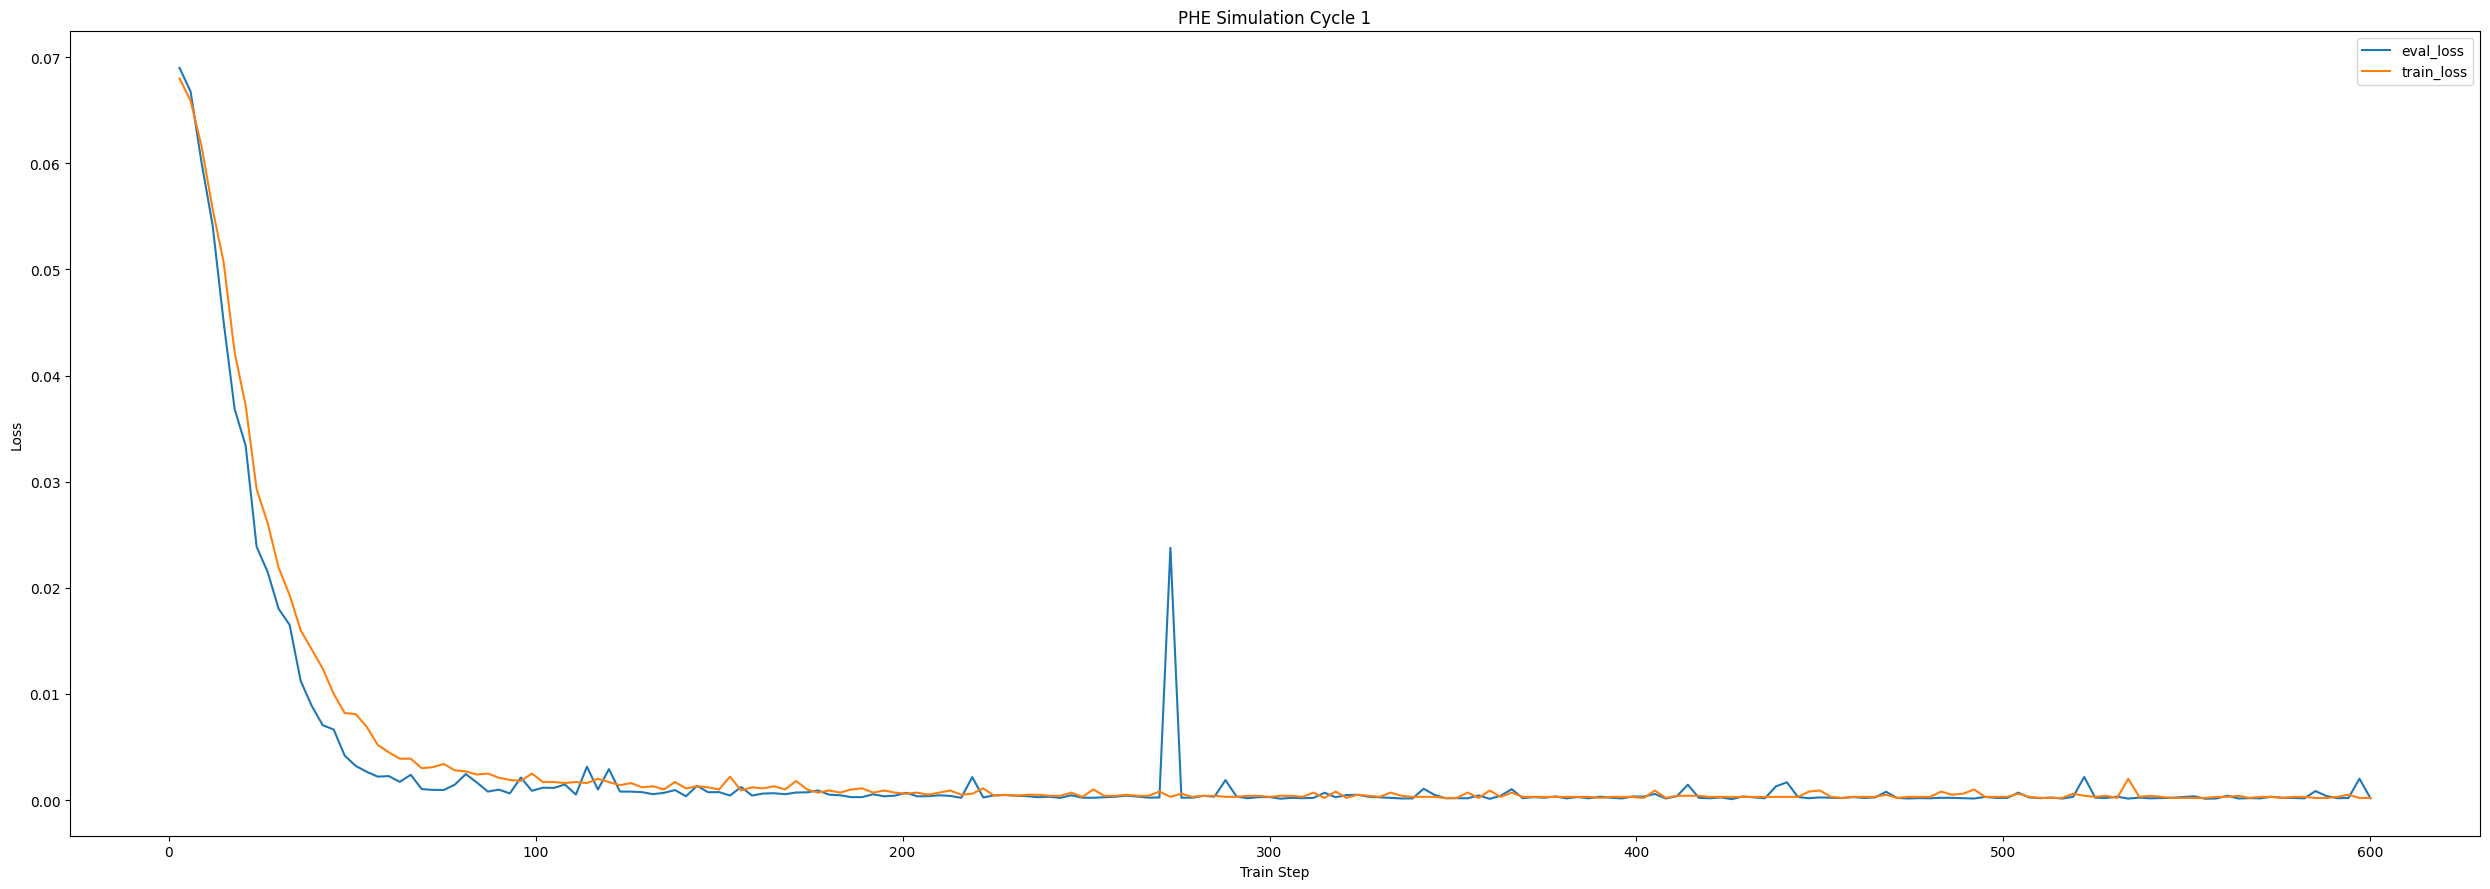

In [ ]:
# visualizing the losses

train_number = 1

fig, ax = plt.subplots(figsize=(25, 9))

# Plot the data for the selected simulation
ax.plot(T1['Step'], T1['eval_loss'],
        label='eval_loss')
ax.plot(T1['Step'], T1['train_loss'],
        label='train_loss')

# ax.set_yscale('log')

# Set the title and labels
ax.set_title(f'PHE Simulation Cycle {train_number}')
ax.set_xlabel('Train Step')
ax.set_ylabel('Loss')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Testing

In [3]:
from datasets import Dataset
import numpy as np
import random
import torch
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

/home/station/sandBox/skrjanc/phe/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model from checkpoint

In [7]:
from transformers import DecisionTransformerModel

train_folder = 1
checkpoint_step_number = 555
checkpoint_dir = "./output/train" + str(train_folder) + "/checkpoint-" + str(checkpoint_step_number)

# Load the model from the checkpoint
# model = DecisionTransformerModel.from_pretrained(checkpoint_dir)
model = TrainableDT.from_pretrained(checkpoint_dir)
model = model.to("cpu")


# train_collator = CustomDataCollator(train_dataset,1)
# config = DecisionTransformerConfig(state_dim=train_collator.state_dim, 
#                                    act_dim=train_collator.act_dim,
#                                    max_ep_len=train_collator.max_ep_len)
# model = TrainableDT(config)

### get_action function for inference

In [8]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, returns_to_go, timesteps):
    # This implementation does not condition on past rewards
    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length:]
    actions = actions[:, -model.config.max_length:]
    returns_to_go = returns_to_go[:, -model.config.max_length:]
    timesteps = timesteps[:, -model.config.max_length:]

    padding = model.config.max_length - states.shape[1]

    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)

    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

### collator -  needed only for state mean state std

In [6]:

#custom data collator
class CustomDataCollator:
    return_tensors: str = "pt"
    max_len: int = 200 #subsets of the episode we use for training
    state_dim: int = 2 # the state space (temperature 1 and current)
    act_dim: int = 1 # the action space (action ~ change to the current, there are 25 different 1x scalar values)
    max_ep_len: int = 10000 # max episode/simulation length
    scale: float = 1000.0 # normalization of rewards/returns ?
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset
    

    def __init__(self, dataset, act_dim) -> None:
        # self.act_dim = len(dataset[0]["actions"][0])
        self.act_dim = act_dim
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        
        # Calculate dataset statistics for normalization of states
        states = []
        traj_lens = []
        for obs in dataset['observations']:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-6
        
        # Initialize p_sample based on trajectory lengths
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
    
    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum
    
    def __call__(self, features):
        batch_size = len(features)
        batch_inds = np.random.choice(np.arange(len(self.p_sample)), size=batch_size, replace=True, p=self.p_sample)
        
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            #for feature in features
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature['rewards']) - 1)
            
            # Get sequences from the dataset
            s.append(np.array(feature['observations'][si : si + self.max_len]).reshape(1, -1, 2))
            a.append(np.array(feature['actions'][si : si + self.max_len]).reshape(1, -1, 1))
            r.append(np.array(feature['rewards'][si : si + self.max_len]).reshape(1, -1, 1))
            
            d.append(np.array(feature['dones'][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            
            # Compute returns-to-go
            rtg.append(self._discount_cumsum(np.array(feature['rewards'][si:]), gamma=1.0)[:s[-1].shape[1]].reshape(1, -1, 1))

            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true, shape not same, concating zeros to match")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)
            
            # Padding and normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))
        
        # Convert to PyTorch tensors
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()
        
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        } 

### setup

In [9]:
# Load testing dataset
test_dataset = Dataset.from_parquet("/home/station/sandBox/skrjanc/phe/train_data/final/test_dataset.parquet")

# Get the state and action dimensions from the model configuration

state_dim = model.config.state_dim      #basically 2 int
act_dim = model.config.act_dim          #basically 1 int

####### WAT DO
max_ep_len = 10000
device = "cpu"
scale = 1000.0

# 95000 cuz that is aprox the range of sum(rewards) of a specific simulation, check section "Simple checks and selecting useful data"
TARGET_RETURN = 95000 / scale 

# Normalize the states using the mean and standard deviation from the data collator
collator = CustomDataCollator(test_dataset,1)
# state_mean = collator.state_mean.astype(np.float32)
# state_std = collator.state_std.astype(np.float32)

state_mean = torch.from_numpy(collator.state_mean).to(device="cpu")  #does not work TypeError: expected np.ndarray (got NoneType)
state_std = torch.from_numpy(collator.state_std).to(device="cpu")


### full script testing

In [54]:
import matlab.engine
import numpy as np
import torch

# Start MATLAB engine
eng = matlab.engine.start_matlab()
eng.cd(r'./matlab_PHE/PHE/PHE', nargout=0)

# set total timesteps
total_timesteps = 9999

# Initialize variables
states_full = torch.zeros((0, 3), dtype=torch.float32) # this one is to store the full states, but for the DT model we only need two states so dim == 2
states = torch.zeros((0, state_dim), device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim),device=device, dtype=torch.float32)
rewards = torch.zeros(0, dtype=torch.float32)
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1,1)
timesteps = torch.zeros((0,1), device=device, dtype=torch.long)

#generate random initial state
start_temp = np.random.randint(20,80)
start_current = np.random.randint(4,20)
start_d = eng.get_initial_temp()
current_state = [start_temp, start_current, start_d]

previous_state = [0,0,0]

# initial M.F_p
M_F_p = 0.5266

# Generate shift points and M_F_p_shifts
num_of_shifts = np.random.randint(2, 9)
k_shifts = np.sort(np.random.choice(total_timesteps - 100, num_of_shifts, replace=False) + 100)
M_F_p_shifts = np.random.uniform(0.6, 0.81, size=num_of_shifts)

# Simulation loop
for t in range(1, total_timesteps + 1):
    # print('iteration: ', t)
    # Get the current state
    current_temp, current_current, current_d = current_state


    # Update states and timesteps
    states_full = torch.cat([states_full, torch.tensor([[current_temp, current_current, current_d]], dtype=torch.float32)], dim=0)
    states = torch.cat([states, torch.tensor([[current_temp, current_current]], dtype=torch.float32)], dim=0)
    timesteps = torch.cat([timesteps, torch.tensor([[t]], dtype=torch.long)], dim=0)
    
    # Update actions, rewards, and target returns
    if t == 1:
        # For the first timestep, initialize actions, rewards, and target returns with placeholder values
        actions = torch.cat([actions, torch.tensor([[0.0]], dtype=torch.float32)], dim=0)
        rewards = torch.cat([rewards, torch.tensor([[0.0]], dtype=torch.float32)], dim=0)
    else:
        # For subsequent timesteps, use the predicted action, reward, and target return from the previous timestep
        actions = torch.cat([actions, torch.tensor([[predicted_action.item()]], dtype=torch.float32)], dim=0)
        rewards = torch.cat([rewards, torch.tensor([[reward]], dtype=torch.float32)], dim=0)

    # Predict the action using the get_action function
    # print(f"States shape: {states.shape}")
    # print(f"Actions shape: {actions.shape}")
    
    # print(f"Timesteps shape: {timesteps.shape}")
    # print(f"Padding: {padding}")
    # print(f"Attention mask shape: {attention_mask.shape}")
    


    normalized_states = (states - state_mean) / state_std
    predicted_action = get_action(model, normalized_states, actions, target_return, timesteps) 
    # print(f"Predicted action: {predicted_action}")

    # check if the current timestep is a shift point and chang M.F_p if it is
    if t in k_shifts:
        shift_index = np.where(k_shifts == t)[0][0]
        M_F_p = M_F_p_shifts[shift_index]
    
    # Call the MATLAB simulation function with the predicted action and shift information

    new_state, reward = eng.simulate_phe(
        float(predicted_action.item()), 
        matlab.double(current_state),
        matlab.double(previous_state),
        float(t), 
        matlab.double(k_shifts.tolist()), 
        matlab.double(M_F_p), 
        nargout=2
    )
    # Update the current state
    previous_state = current_state
    current_state = new_state[0]

    # Calculate the predicted return for the next timestep
    # print(f"target return: {target_return.shape}")
    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    # print(f"target return: {target_return.shape}")
    # Evaluate the model's performance (if needed)
    # evaluate_model(predicted_action, reward)

# Further processing and analysis of the collected data
# process_data(states, actions, rewards)

Shift at timestep 4924: M.F_p set to 0.695179
Shift at timestep 7051: M.F_p set to 0.697189
Shift at timestep 7894: M.F_p set to 0.757423


In [24]:
num_of_shifts = np.random.randint(2, 9)
k_shifts = np.sort(np.random.choice(total_timesteps - 100, num_of_shifts, replace=False) + 100)
M_F_p_values = [0.6, 0.8]
indices = np.random.randint(0, 2, size=num_of_shifts)
M_F_p_shifts = [M_F_p_values[i] for i in indices]

print('k_shifts: ', k_shifts, 'mfp value: ', M_F_p_shifts )

k_shifts:  [ 686  818 3181 5672 7239 7518 8046 9226] mfp value:  [0.4, 0.4, 0.9, 0.4, 0.9, 0.9, 0.4, 0.9]


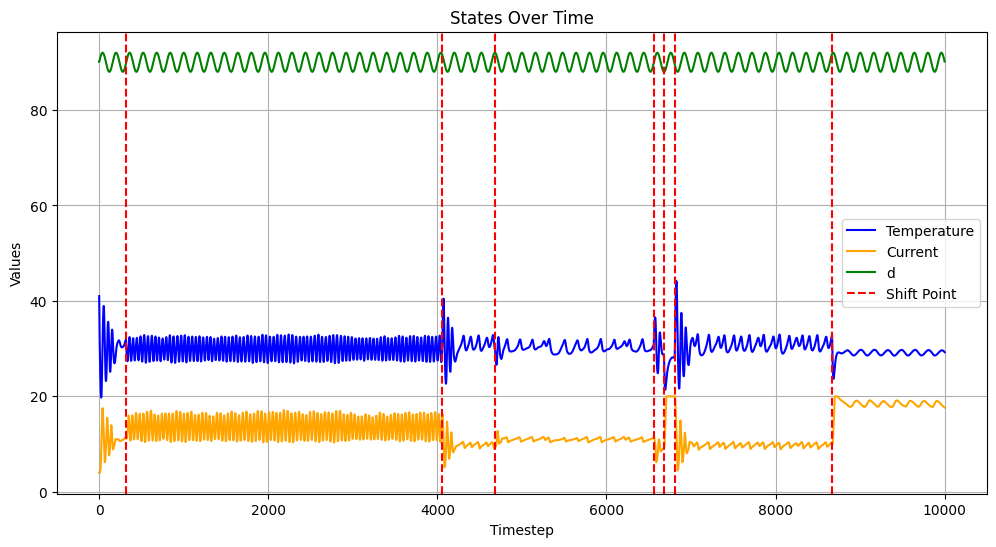

In [53]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
states_full_np = states_full.numpy()
timesteps_np = timesteps.numpy()

# Flatten the timesteps array
timesteps_flat = timesteps_np.flatten()

# Plot all states in one graph
plt.figure(figsize=(12, 6))

plt.plot(timesteps_flat, states_full_np[:, 0], label='Temperature', color='blue')
plt.plot(timesteps_flat, states_full_np[:, 1], label='Current', color='orange')
plt.plot(timesteps_flat, states_full_np[:, 2], label='d', color='green')

# Add vertical lines at shift points
for shift in k_shifts:
    plt.axvline(x=shift, color='red', linestyle='--', label='Shift Point' if shift == k_shifts[0] else "")

plt.xlabel('Timestep')
plt.ylabel('Values')
plt.title('States Over Time')
plt.legend()
plt.grid(True)

plt.show()

